# Um estudo sobre Sistemas de Recomendação 🎥

> "O maior inimigo do conhecimento não é ignorância,
> mas sim a ilusão de conhecimento."
> -Stephen Hawking

  
## Objetivo

O objetivo principal deste notebook é a construção de um guia técnico para desenvolvimento de Sistemas de Recomendação. Utiliza-se como referência prática os notebooks apresentados em [Film recommendation engine](https://www.kaggle.com/fabiendaniel/film-recommendation-engine), [Netflix Visualizations, Recommendation, EDA](https://www.kaggle.com/niharika41298/netflix-visualizations-recommendation-eda) e [Getting Started with a Movie Recommendation System](https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system), além é claro de referências teóricas como [A hybrid recommender system based-on link prediction for movie baskets analysis](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00422-0) e [Recommender Systems Handbook](https://link.springer.com/book/10.1007/978-0-387-85820-3).

O estudo será pautado em cima da base de dados [MovieLens 100k Dataset](https://www.kaggle.com/prajitdatta/movielens-100k-dataset), objeto que representa a coleta de 100,000 avaliações (que variam de 1 a 5) de 943 usuários sobre 1682 filmes do site MovieLens entre os anos de 97 e 98. Também está disponível as informações básicas de cada usuário na base, praticamente encontramos Gênero, Idade, Profissão e Endereço.

O sistema funcionará a partir de uma função que poderá receber como parâmetro o ID de um usuário ou o ID de um filme, e retornará uma lista dos filmes mais próximos da referência dada. Indicando uma boa recomendação futura.

Na prática, a função utilizará de alguns critérios técnicos para obter as recomendações, sendo elas:

#### Abordagens Tradicionais

- **Filtragem demográfica baseada em popularidade**: O mais simples dos algorítmos de recomendação e o mais impessoal considerando os que vamos falar por aqui, utilizará as informações de cada pessoa para cola-las em grupos de usuários parecidos, dai utilizará as avaliações dadas por esse grupo para indicar a recomendação. É o famoso "O que está bombando na Netflix" -- dado o grupo que você pertence.

- **Filtragem Colaborativa baseada em modelo:** Sistemas que utilizam esta abordagem assumem que um usuário deve gostar de itens bem avaliados por usuários com gostos parecidos. Gera recomendações mais personalizadas do que a abordagem acima.

#### ✨Abordagens Contemporâneas ✨

- **Filtragem Colaborativa baseada em Redes Complexas (Link Prediction):** É uma extensão das abordagens colaborativas baseadas em modelo. Elas também são conhecidas por identificar bem a vizinhança a qual um nó (usuário) pertence com base no que ele assiste, e ainda por cima também é interessante para indicar filmes que fujam do padrão dessa vizinha, mas que ainda sejam de interesse dela.



 ## Luz, Câmera, Ação!

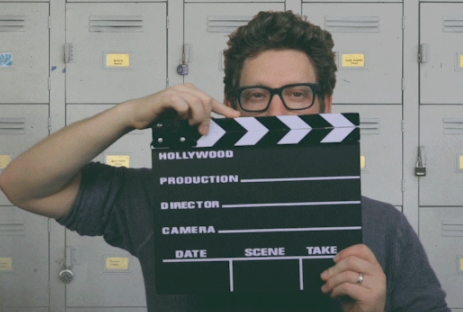

  Este notebook está organizado da seguinte maneira:
 
 1. **Bibliotecas Utilizadas**
 2. **Preparação dos Dados**
 
     - Leitura
     - Nomeação das colunas e limpeza de colunas sem função
     - Adaptação dos tipos de dados
     - Tratativa de valores faltantes
     - Obtenção do ESTADO dos EUA ao qual o usuário pertence
     
 
 3. **Análise Exploratória dos Dados**
 
     - Histogramas e Boxplots da quantidade de avaliações de cada filme
     - Histogramas e Boxplots da avaliação média recebida por cada filme
     - Top 10 filmes por quantidade de avaliações
     - Top 10 filmes por avaliação média recebida
     - Scatterplot da correlação entre avaliação média recebida por cada filme vs a quantidade de avaliações recebidas por cada filme
     - Barplot com os gêneros que mais receberam avaliações
     - Lollipopplot da quantidade de filmes lançados por ano
     - Barplot da quantidade de avaliações por gênero
     - Barplot da quantidade de avaliações por estado (EUA)
     - Barplot da quantidade de avaliações por profissão
     
     
 4. **Sistema de Recomendação**
 
     - Popularidade
     - Popularidade nos últimos tempos
     - Popularidade demográfica
     - Baseados em conteúdo (usuários)
     - Filtragem colaborativa
     
     
 5. **Interpretação dos Resultados**

 ## 1. Bibliotecas Utilizadas
 
 - Pandas
 - Datetime
 - Matplotlib
 - Seaborn
 - Datetime
 - Pyzipcode
 - Warnings

In [2]:
!pip install pyzipcode

In [3]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pyzipcode import ZipCodeDatabase
import warnings

warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
%matplotlib inline

## 2. Preparação dos Dados

### Base de interações

In [4]:
#Leitura dos dados de interação via pandas, arquivo é um tsv (texto separado por tab)
nomes_das_colunas=['id_usuario','id_filme','avaliacao','data_avaliacao']
df=pd.read_csv("archive/ml-100k/u.data",sep="\t",names=nomes_das_colunas)

#Conversão do formato data da avaliação que estava em Unix
data_inicio_unix = datetime(1970, 1, 1)
df['data_avaliacao'] = df.data_avaliacao.apply(lambda x: data_inicio_unix + timedelta(seconds=x)).dt.date

#Colocar as colunas de ID como texto
df['id_usuario'] = df['id_usuario'].astype(str)
df['id_filme'] = df['id_filme'].astype(str)

print('\nQuantidade de linhas na base de dados:', df.shape[0],'\nQuantidade de colunas na base de dados:', df.shape[1],'\n')
df.head()


Quantidade de linhas na base de dados: 100000 
Quantidade de colunas na base de dados: 4 



,id_usuario,id_filme,avaliacao,data_avaliacao
0,196,242,3,1997-12-04
1,186,302,3,1998-04-04
2,22,377,1,1997-11-07
3,244,51,2,1997-11-27
4,166,346,1,1998-02-02


Verificando a existência de valores faltantes

In [5]:
#Nenhum foi encontrado
df.count()

id_usuario        100000
id_filme          100000
avaliacao         100000
data_avaliacao    100000
dtype: int64

### Base com dados sobre os filmes

In [6]:
#Leitura dos metadados dos filmes via pandas, arquivo agora é separado por |
nomes_das_colunas=['id_filme','nome_filme','data_lancamento','data_lancamento_dvd','IMDb_url', 
                   'tema_desconhecido', 'tema_acao', 'tema_aventura','tema_animacao','tema_criancas',
                   'tema_comedia','tema_crime','tema_documentario', 'tema_drama', 'tema_fantasia',
                   'tema_preto_branco','tema_horror','tema_musical','tema_misterio', 'tema_romance',
                   'tema_fic_cientifica','tema_suspense', 'tema_guerra','tema_velho_oeste']
df_item=pd.read_csv("archive/ml-100k/u.item",sep="\|",names=nomes_das_colunas, engine='python')

#Deletamos alguns colunas que não tinham informações relevantes para a analise
df_item.drop(columns=['data_lancamento_dvd','IMDb_url'], inplace=True)

#Colocar a coluna de ID como texto
df_item['id_filme'] = df_item['id_filme'].astype(str)

print('\nQuantidade de linhas na base de dados:', df_item.shape[0],'\nQuantidade de colunas na base de dados:', df_item.shape[1],'\n')
df_item.head()


Quantidade de linhas na base de dados: 1682 
Quantidade de colunas na base de dados: 22 



,id_filme,nome_filme,data_lancamento,tema_desconhecido,tema_acao,tema_aventura,tema_animacao,tema_criancas,tema_comedia,tema_crime,...,tema_fantasia,tema_preto_branco,tema_horror,tema_musical,tema_misterio,tema_romance,tema_fic_cientifica,tema_suspense,tema_guerra,tema_velho_oeste
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


Verificando a existência de valores faltantes:

In [7]:
df_item.count()

id_filme               1682
nome_filme             1682
data_lancamento        1681
tema_desconhecido      1682
tema_acao              1682
tema_aventura          1682
tema_animacao          1682
tema_criancas          1682
tema_comedia           1682
tema_crime             1682
tema_documentario      1682
tema_drama             1682
tema_fantasia          1682
tema_preto_branco      1682
tema_horror            1682
tema_musical           1682
tema_misterio          1682
tema_romance           1682
tema_fic_cientifica    1682
tema_suspense          1682
tema_guerra            1682
tema_velho_oeste       1682
dtype: int64

Verificamos que um filme na base de dados possui tema desconhecido, sem nome e sem data de lançamento. Provavelmente um erro.

O id do filme é o 267.

In [8]:
df_item[df_item['data_lancamento'].isna()]

,id_filme,nome_filme,data_lancamento,tema_desconhecido,tema_acao,tema_aventura,tema_animacao,tema_criancas,tema_comedia,tema_crime,...,tema_fantasia,tema_preto_branco,tema_horror,tema_musical,tema_misterio,tema_romance,tema_fic_cientifica,tema_suspense,tema_guerra,tema_velho_oeste
266,267,unknown,NaN,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Vamos eliminar a unica com valores faltantes:

In [9]:
df_item.drop(df_item[df_item['data_lancamento'].isna()].index, inplace=True)

Precisamos eliminar as linhas que também contenham avaliação para este filme desconhecido na base de interações.

In [10]:
df[df['id_filme']==267]

,id_usuario,id_filme,avaliacao,data_avaliacao


Vamos eliminar as linhas com avaliacoes desse filme

In [11]:
df.drop(df[df['id_filme']==267].index, inplace=True)

### Base com dados sobre os usuários

In [12]:
#Leitura dos metadados de usuarios via pandas, arquivo é separado por |
nomes_das_colunas=['id_usuario','idade','sexo','profissao','cep']
df_usuarios=pd.read_csv("archive/ml-100k/u.user",sep="\|",names=nomes_das_colunas, engine='python')

#Colocar a coluna de ID como texto
df_usuarios['id_usuario'] = df_usuarios['id_usuario'].astype(str)

print('\nQuantidade de linhas na base de dados:', df_usuarios.shape[0],'\nQuantidade de colunas na base de dados:', df_usuarios.shape[1],'\n')
df_usuarios.head()


Quantidade de linhas na base de dados: 943 
Quantidade de colunas na base de dados: 5 



,id_usuario,idade,sexo,profissao,cep
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


Verificando a existência de valores faltantes

In [13]:
#Nenhum foi encontrado
df_usuarios.count()

id_usuario    943
idade         943
sexo          943
profissao     943
cep           943
dtype: int64

Substituição do campo cep (zip code no USA) pelo estado ao qual ao qual o usuario de fato pertence.

Assumimos que os zip_codes nao encontrados pela biblioteca são de fora dos EUA.

In [14]:
zcdb = ZipCodeDatabase()
lista_auxiliar = []
for zip_code in df_usuarios['cep'].values:
    try:
        zipcode = zcdb[int(zip_code)]
        lista_auxiliar.append(zipcode.state)
    except:
        lista_auxiliar.append('OUT')
df_usuarios['estado_usa'] = lista_auxiliar

#Deletamos a coluna do CEP porque não precisaremos mais dela
df_usuarios.drop(columns=['cep'], inplace=True)

## 3. Análise Exploratória dos Dados

Preparativos prontos, vamos para algumas análises rápidas sobre os dados

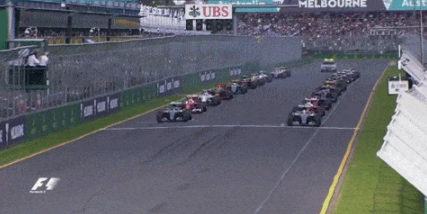

#### Histrograma da quantidade de avaliações

Criando um dataframe temporário para analisar a distribuição das avaliações e suas quantidades

In [15]:
df_agrupado = df[['id_filme','avaliacao']].groupby(by='id_filme').agg(['count','mean'])['avaliacao'].reset_index()

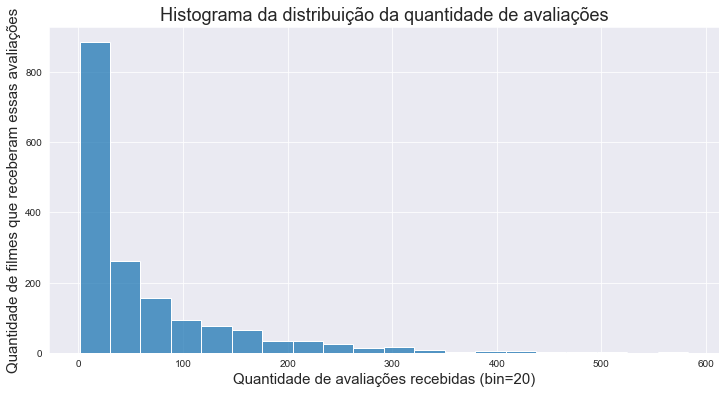

In [16]:
plt.figure(figsize=(12,6))
sns.histplot(df_agrupado['count'], bins=20)
plt.title('Histograma da distribuição da quantidade de avaliações', fontsize=18)
plt.xlabel('Quantidade de avaliações recebidas (bin=20)', fontsize=15)
plt.ylabel('Quantidade de filmes que receberam essas avaliações', fontsize=15)
plt.show()

Este gráfico é interessante, mostra a distribuição da quantidade de avaliações recebidas pelos filmes. A leitura é simples, no eixo X temos a quantidade de avaliações recebidas pelo filme, separadas por grupos de 20. Já no eixo Y temos a quantidade de filmes que receberam essa quantidade de avaliações mencionada no eixo X. Em outras palavras, temos que mais de 800 filmes receberam até 20 avaliações. Isso demonstra a assimetria a direita na distribuição, ou seja, muitos filmes possuem poucas avaliações a poucos filmes recebem muitas avaliações.

#### Boxplot da quantidade de avaliações

Isso pode também ser confirmado pelo gráfico de boxplot, onde podemos notar que a linha preta no meio da pilha (mediana da quantidade de avaliações) está mais perto da primeira linha horizontal (1º quartil), e alguns outros outliers podem ser encontrados na parte superior (pontos pretos).

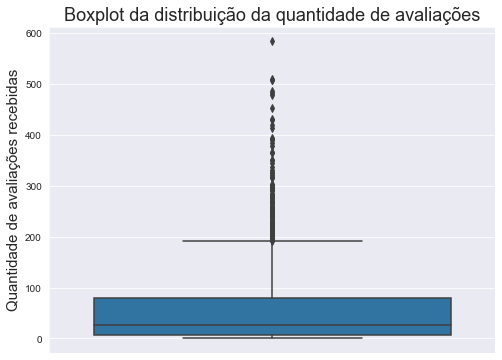

In [17]:
plt.figure(figsize=(8,6))
sns.boxplot(y = 'count', data = df_agrupado)
plt.title('Boxplot da distribuição da quantidade de avaliações', fontsize=18)
plt.ylabel('Quantidade de avaliações recebidas', fontsize=15)
plt.show()

#### Histrograma da média de avaliações

Da mesma maneira pode ser interessante analisar a média das avaliações dadas pelos usuários, então:

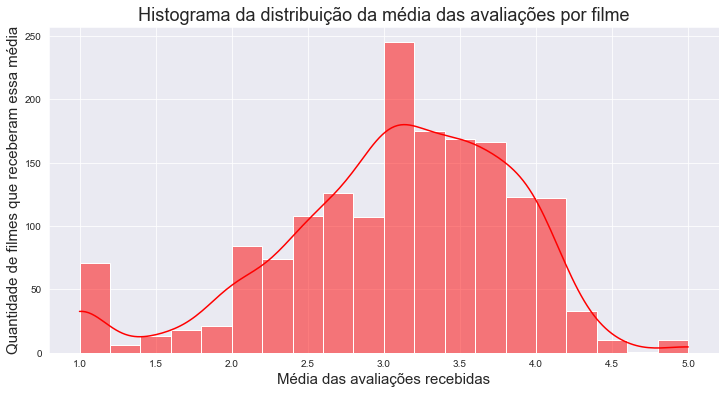

In [18]:
plt.figure(figsize=(12,6))
sns.histplot(df_agrupado['mean'], bins=20, kde=True, color='red')
plt.title('Histograma da distribuição da média das avaliações por filme', fontsize=18)
plt.ylabel('Quantidade de filmes que receberam essa média', fontsize=15)
plt.xlabel('Média das avaliações recebidas', fontsize=15)
plt.show()

#### Boxplot da média de avaliações

Tanto com o histograma acima, como com o boxplot abaixo podemos notar uma concentração maior das médias de avaliações dos filmes entre 2,5 e 3,7. Mas a mediana por volta dos 3,2. Há ainda uma quantidade boa de filmes que tenham recebido nota média inferior a 2 e poucos que tenham recebido nota média por volta do 5.

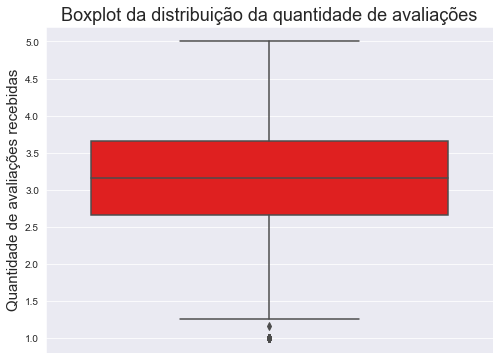

In [19]:
plt.figure(figsize=(8,6))
sns.boxplot(y = 'mean', data = df_agrupado, color='red')
plt.title('Boxplot da distribuição da quantidade de avaliações', fontsize=18)
plt.ylabel('Quantidade de avaliações recebidas', fontsize=15)
plt.show()

#### A relação entre média e quantidade de avaliações

Precisamente temos uma mediana geral de 27 avaliações por filme e uma nota médiana geral de 3,16.

In [20]:
df_agrupado.median()

id_filme    841.500000
count        27.000000
mean          3.161528
dtype: float64

Mas abrindo ainda mais esses números pelos filmes em sí, podemos enxergar...

In [21]:
#Criando um dataframe temporário para a análise em questão
df_agrupado = df_agrupado.reset_index().merge(df_item, left_on='id_filme', right_on='id_filme', how='left')

Top 10 filmes que mais receberam avaliações:

In [22]:
df_agrupado[['nome_filme','count']].sort_values(by='count', ascending=False).head(10)

,nome_filme,count
1128,Star Wars (1977),583
859,Contact (1997),509
2,Fargo (1996),508
774,Return of the Jedi (1983),507
899,Liar Liar (1997),485
890,"English Patient, The (1996)",481
892,Scream (1996),478
0,Toy Story (1995),452
907,Air Force One (1997),431
235,Independence Day (ID4) (1996),429


Top 10 filmes mais bem avaliados (com pelo menos 50 avaliações cada):

In [23]:
df_agrupado[df_agrupado['count'] > 50][['nome_filme','mean', 'count']].sort_values(by='mean', ascending=False).head(10)

,nome_filme,mean,count
1026,"Close Shave, A (1995)",4.491071,112
926,Schindler's List (1993),4.466443,298
760,"Wrong Trousers, The (1993)",4.466102,118
1109,Casablanca (1942),4.456790,243
157,Wallace & Gromit: The Best of Aardman Animatio...,4.447761,67
1283,"Shawshank Redemption, The (1994)",4.445230,283
1243,Rear Window (1954),4.387560,209
223,"Usual Suspects, The (1995)",4.385768,267
1128,Star Wars (1977),4.358491,583
770,12 Angry Men (1957),4.344000,125


Será que podemos dizer que os filmes mais avaliados, o que é uma proxy para talvez os filmes mais vistos, também são os filmes melhor avaliados? De fato, apesar de existir alguma correlação entre essa quantidades, ela não é tão alta. Precisamente de 0,4. Então nem sempre isso é verdade, apesar de existir uma certa tendência.

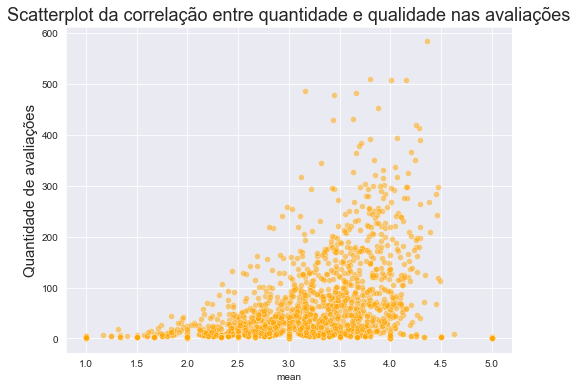

In [24]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='mean',y='count',data=df_agrupado,alpha=0.5, color='orange')
plt.title('Scatterplot da correlação entre quantidade e qualidade nas avaliações', fontsize=18)
plt.ylabel('Média das avaliações', fontsize=15)
plt.ylabel('Quantidade de avaliações', fontsize=15)
plt.show()

In [25]:
#Os números de correlação exatos vieram daqui:
df_agrupado[['mean','count']].corr()

,mean,count
mean,1.000000,0.429659
count,0.429659,1.000000


#### Quais são os temas que mais receberam avaliações

Lembrando que um filme pode pertencer a mais de um tema (irei contar então todas as vezes, para simplificar), temos a seguinte análise a ser feita:

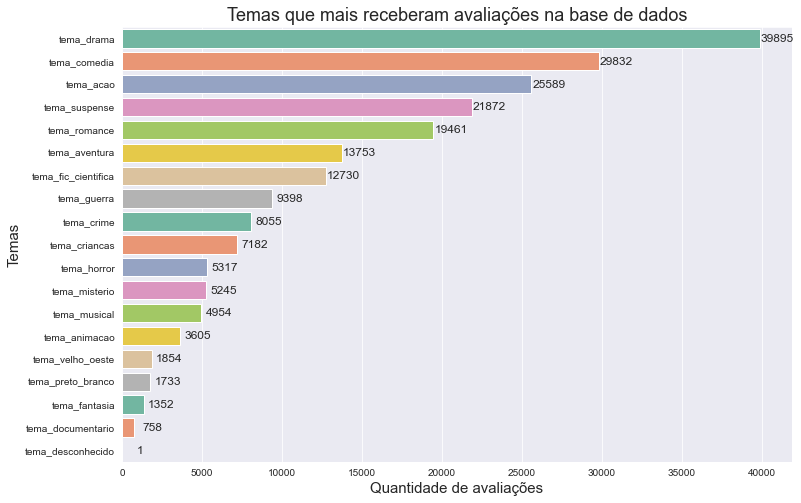

In [26]:
#Preparação do dado para a plotagem
cols = df_agrupado.columns[6:]
dict_cols = {coluna:0 for coluna in cols}

for i in df_agrupado.index:
    for coluna in cols:
        if (df_agrupado.iloc[i][coluna] == 1):
            dict_cols[coluna] += df_agrupado.iloc[i]['count']
dict_cols = {k: v for k, v in sorted(dict_cols.items(), key=lambda item: item[1], reverse=True)}

#plotagem
plt.figure(figsize=(12,8))
plt.title('Temas que mais receberam avaliações na base de dados', fontsize=18)
plt.ylabel('Temas', fontsize=15)
plt.xlabel('Quantidade de avaliações', fontsize=15)
sns.set(style="darkgrid")
ax = sns.barplot(x=list(dict_cols.values()), y=list(dict_cols.keys()),  palette="Set2")

for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), 
                   (p.get_width() + 1100, (p.get_height()) +  p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.show()

Temos que o Drama foi o tema que mais recebeu avaliações, seguido por comédia e ação.

#### Quantidade de filmes publicados por ano

Analisando a quantidade de filmes publicados por ano podemos ver que alguns filmes bem antigos estão sendo avaliados mesmo depois de varios anos, mas o pico nos ultimos 5 anos ainda é o que mais representa a base de dados.

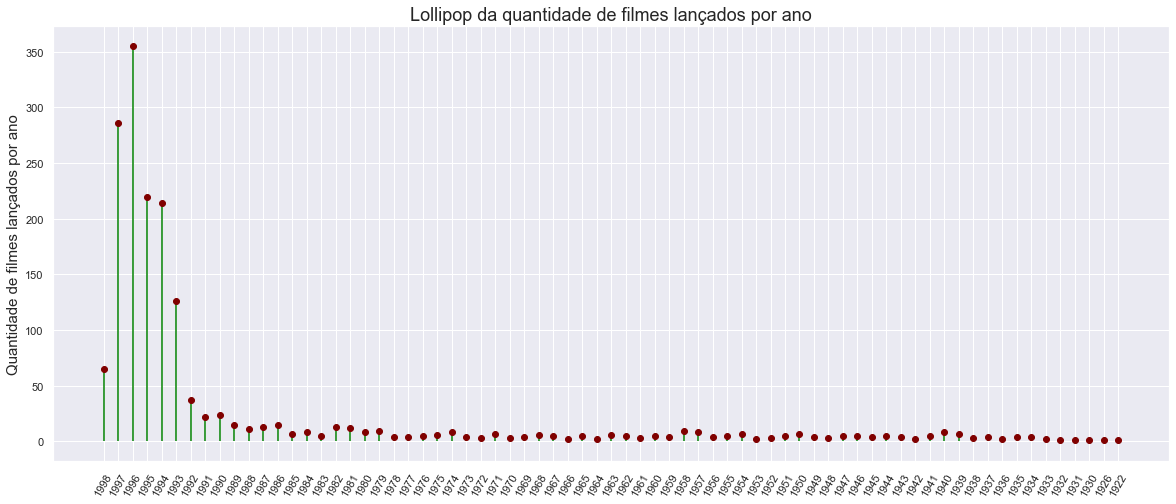

In [27]:
df_item['year'] = df_item['data_lancamento'].str[-4:]
g = df_item[['year','id_filme']].groupby(by='year').count().to_dict()
g = g['id_filme']
fig, ax = plt.subplots(figsize = (20, 8))

x=list(g.keys())[::-1]
y=list(g.values())[::-1]
ax.vlines(x, ymin=0, ymax=y, color='green')
ax.plot(x,y, "o", color='maroon')
ax.set_xticklabels(x, rotation = 60)
ax.set_ylabel("Quantidade de filmes lançados por ano", fontsize=15)
# set a title
ax.set_title("Lollipop da quantidade de filmes lançados por ano", fontsize=18)
plt.show()

#### Quantidade de avaliações por gênero

Analisando a quantidade de avaliações feitas por gênero temos que os homens tem maior presença na base de dados. Cerca de 2.9x mais avaliações.

In [28]:
df = df.merge(df_usuarios, left_on='id_usuario', right_on='id_usuario', how='left')

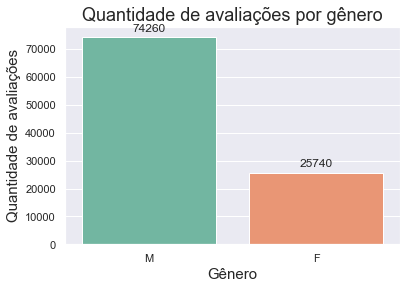

In [29]:
plt.figure()
ax = sns.countplot(x="sexo", data=df, palette="Set2")
sns.set(style="darkgrid", rc={'figure.figsize':(12,8)})
plt.title('Quantidade de avaliações por gênero', fontsize=18)
plt.ylabel('Quantidade de avaliações', fontsize=15)
plt.xlabel('Gênero', fontsize=15)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.show()

#### Quantidade de avaliações por estado (EUA)

Analisando a quantidade de avaliações feitas por cada estado dos EUA na base. Temos que os Califórnia, Minnesota e Nova Iorque são os que tem maior presença na base de dados.

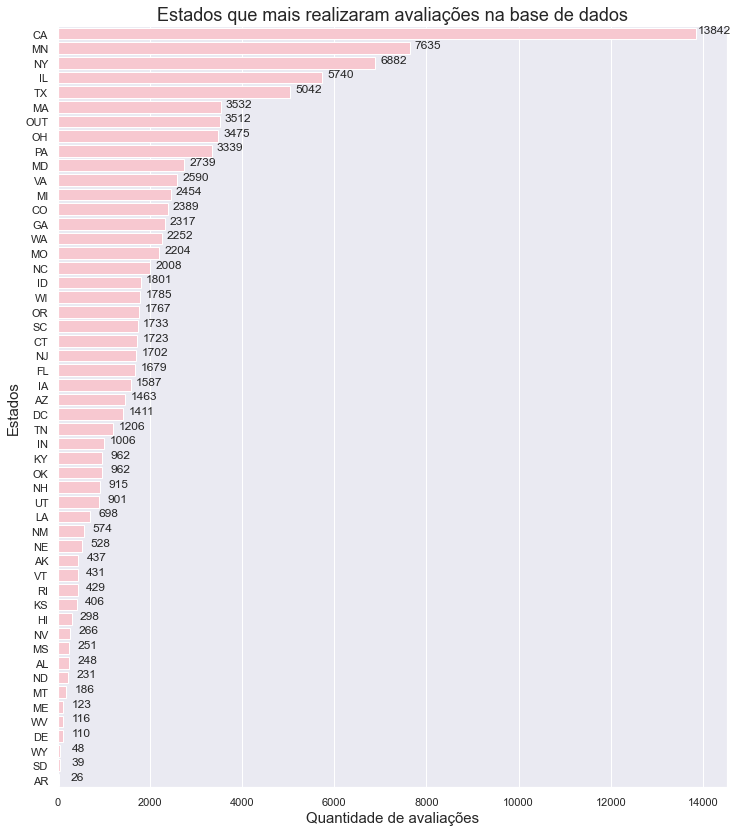

In [30]:
#Preparação do dado para a plotagem
dict_cols = df.groupby(by='estado_usa').count().to_dict()['id_usuario']
dict_cols = {k: v for k, v in sorted(dict_cols.items(), key=lambda item: item[1], reverse=True)}

#plotagem
plt.figure(figsize=(12,14))
plt.title('Estados que mais realizaram avaliações na base de dados', fontsize=18)
plt.ylabel('Estados', fontsize=15)
plt.xlabel('Quantidade de avaliações', fontsize=15)
sns.set(style="darkgrid")
ax = sns.barplot(x=list(dict_cols.values()), y=list(dict_cols.keys()),  color='pink')
    
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), 
                   (p.get_width() + 400, (p.get_height()) +  p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
plt.show()

#### Quantidade de avaliações por profissão

Analisando a quantidade de avaliações feitas por cada profissão na base. Temos que os estudantes são os que tem maior presença na base de dados. Cerca de 2x mais avaliações que a segunda categoria.

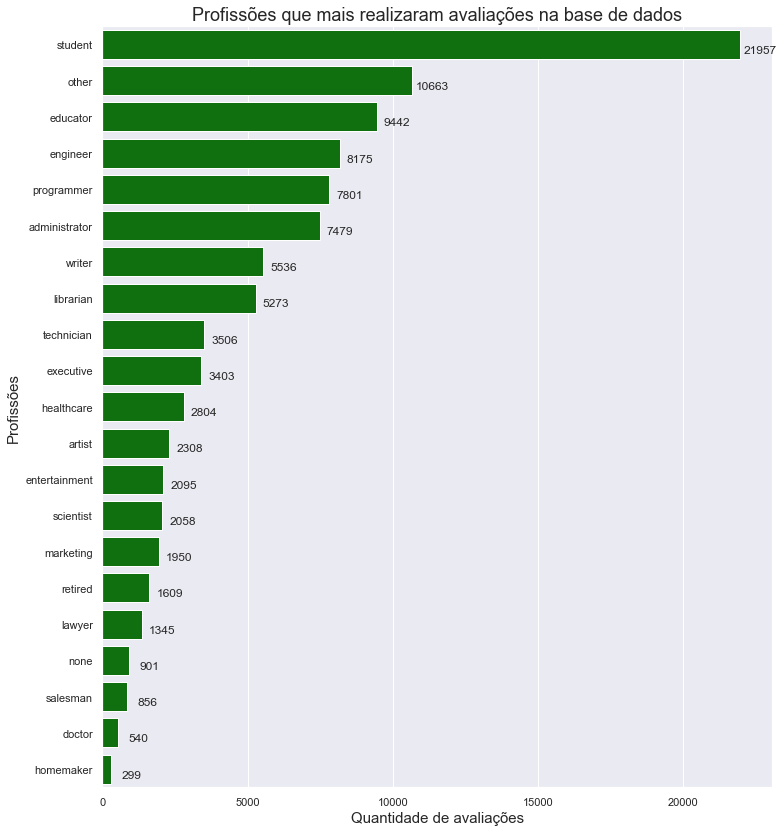

In [31]:
#Preparação do dado para a plotagem
dict_cols = df.groupby(by='profissao').count().to_dict()['id_usuario']
dict_cols = {k: v for k, v in sorted(dict_cols.items(), key=lambda item: item[1], reverse=True)}

#plotagem
plt.figure(figsize=(12,14))
plt.title('Profissões que mais realizaram avaliações na base de dados', fontsize=18)
plt.ylabel('Profissões', fontsize=15)
plt.xlabel('Quantidade de avaliações', fontsize=15)
sns.set(style="darkgrid")
ax = sns.barplot(x=list(dict_cols.values()), y=list(dict_cols.keys()),  color='green')
    
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), 
                   (p.get_width() + 700, (p.get_height()) +  p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
plt.show()

## 4. Sistema de Recomendação

### Popularidade

Como mencionado no início, a abordagem baseada em popularidade é a mais simples de todas. Olha diretamente para como este filme está se destacando dentre os outros dado critérios de quantidade e qualidade das avaliações recebidas, mas não distingue metadados de usuários e nem de filmes. É uma recomendação mais generalista. É o famoso "O que está bombando na Netflix".

O pipeline do nosso desenvolvimento seguirá os seguintes passos:

- Definir uma métrica de popularidade que relacione quantidade e qualidade das avaliações
- Aplicar esta métrica para os filmes da base
- Ordenar o resultado e apresentar o top-N

O primeiro ponto é muito importante para o prosseguimento, uma vez que podemos encontrar filmes muito bem avaliados que ainda não tenham uma quantidade rasoável de avaliações recebidas para ponderar a média. Poderíamos ter, por exemplo, um filme com 6 avaliações e uma média de 5, que não necessáriamente seria melhor que um outro filme que possuísse 90 avaliações e uma média de 4.7 . Neste caso, estaremos utilizando uma métrica desenvolvida pelo IMDb (Internet Movie Database) que visa balancear estes pesos.

Seja WR a média ponderada do IMDb, temos:

WR = ( R\*v + C*m ) / ( v+m )

onde,

- R --> média das avaliações recebidas por um filme
- v --> quantidade de avaliações recebidas por um filme
- C --> média de todas as avaliações da base de dados
- m --> é o mínimo de avaliações que um filme precisa para entrar no ranking

Para m, vou assumir que o 90º percentil é um bom número para ser utilizado como linha de corte. Ou seja, sempre que um filme estiver acima desse valor, ele receberá a métrica de popularidade e poderá ser retornado pela função.

Bora definir esta função então!

In [32]:
def wr_imdb(dataframe, nome_coluna_avaliacoes='avaliacao', nome_coluna_id_filme='id_filme', percentil_minimo_avaliacoes=0.9):
    """
    Função que executa a métrica de média ponderada definida pela IMDB
    
    
    Parâmetros
    ----------
    dataframe: DataFrame
        Pandas DataFrame que contem as informações necessárias para aplicação da função
    nome_coluna_avaliacoes: String
        O nome da coluna ao qual a formula será aplicada
    nome_coluna_id_filme: String
        O nome da coluna que identifica cada filme na base de dados
    percentil_minimo_avaliacoes: Float
        A quantidade do percentil que reflete o mínimo de avaliações necessárias para que um filme possa ser ranqueado
        
    
    Retorno
    ----------
    DataFrame
        Um Pandas DataFrame contendo em uma coluna o identificador de cada filme único na base e numa outra coluna a métrica de popularidade aplicada.
    """
    
    dataframe_auxiliar = dataframe[[nome_coluna_id_filme,nome_coluna_avaliacoes]].groupby(by=nome_coluna_id_filme).agg(['count','mean'])[nome_coluna_avaliacoes].reset_index()
    
    C = dataframe[nome_coluna_avaliacoes].mean()
    m = dataframe_auxiliar['count'].quantile(percentil_minimo_avaliacoes)
    
    lista_auxiliar = []
    for i in dataframe_auxiliar.index:
        if (dataframe_auxiliar.iloc[i]['count'] < m):
            lista_auxiliar.append(1)
        else:
            R = dataframe_auxiliar.iloc[i]['mean']
            v = dataframe_auxiliar.iloc[i]['count']
            lista_auxiliar.append( ( R*v + C*m ) / (v+m) )
    
    dataframe_auxiliar['popularidade'] = lista_auxiliar
    
    return dataframe_auxiliar[[nome_coluna_id_filme,'popularidade']].copy()

Vamos aplicar a função à nossa base de dados:

In [33]:
df_resultado_popularidade = wr_imdb(df)

Assim podemos ver os resultados obtidos para as 10 primeiras posições ordenadas pela popularidade.

In [34]:
df_resultado_popularidade.merge(df_item[['id_filme','nome_filme']], left_on='id_filme', right_on='id_filme', how='left').sort_values(by='popularidade', ascending=False).head(10)

,id_filme,popularidade,nome_filme
1128,50,4.172269,Star Wars (1977)
926,318,4.127508,Schindler's List (1993)
1283,64,4.102979,"Shawshank Redemption, The (1994)"
1109,483,4.076569,Casablanca (1942)
301,127,4.064513,"Godfather, The (1972)"
1660,98,4.060011,"Silence of the Lambs, The (1991)"
223,12,4.054005,"Usual Suspects, The (1995)"
766,174,4.045070,Raiders of the Lost Ark (1981)
921,313,4.012613,Titanic (1997)
1243,603,4.004091,Rear Window (1954)


### Popularidade nos últimos tempos

Também pode ser interessante análisar esta métrica de popularidade seguindo algum critério de período. Ou seja, pegar "o que está bombando nos ultimos tempos",e não na base de dados toda sem nenhum critério de busca. A netflix reconhecidamente faz este tipo de abordagem. Vamos ajustar a função definida acima então, acrescentando este parâmetro de período de tempo.

In [35]:
def current_wr_imdb(dataframe, nome_coluna_avaliacoes='avaliacao', nome_coluna_id_filme='id_filme', percentil_minimo_avaliacoes=0.9, periodo_maximo_considerado=30, nome_coluna_data_avaliacao='data_avaliacao'):
    """
    Função que executa a métrica de média ponderada definida pela IMDB, mas apenas para as avaliações feitas no período de tempo passado como parâmetro.
    
    
    Parâmetros
    ----------
    dataframe: DataFrame
        Pandas DataFrame que contem as informações necessárias para aplicação da função
    nome_coluna_avaliacoes: String
        O nome da coluna ao qual a formula será aplicada
    nome_coluna_id_filme: String
        O nome da coluna que identifica cada filme na base de dados
    percentil_minimo_avaliacoes: Float
        A quantidade do percentil que reflete o mínimo de avaliações necessárias para que um filme possa ser ranqueado
    periodo_maximo_considerado: Integer
        A quantidade de dias considerados na janela de análise
    nome_coluna_data_avaliacao: String
        O nome da coluna que contém a data da avaliação feita
        
    
    Retorno
    ----------
    DataFrame
        Um Pandas DataFrame contendo em uma coluna o identificador de cada filme único na base e numa outra coluna a métrica de popularidade aplicada.
    """
    
    dataframe_auxiliar = dataframe.copy()
    dataframe_auxiliar[nome_coluna_data_avaliacao] = pd.to_datetime(dataframe_auxiliar[nome_coluna_data_avaliacao])
    dataframe_auxiliar = dataframe_auxiliar[dataframe_auxiliar[nome_coluna_data_avaliacao] >=  dataframe_auxiliar[nome_coluna_data_avaliacao].max() - pd.Timedelta(days=periodo_maximo_considerado)].copy()
    
    return wr_imdb(dataframe_auxiliar, nome_coluna_avaliacoes, nome_coluna_id_filme, percentil_minimo_avaliacoes)

Vamos aplicar a função à nossa base de dados com um período de 30 dias:

In [36]:
df_resultado_popularidade_atual = current_wr_imdb(df)

Assim podemos ver os resultados obtidos para as 10 primeiras posições ordenadas pela popularidade atual.

In [37]:
df_resultado_popularidade_atual.merge(df_item[['id_filme','nome_filme']], left_on='id_filme', right_on='id_filme', how='left').sort_values(by='popularidade', ascending=False).head(10)

,id_filme,popularidade,nome_filme
691,318,4.209171,Schindler's List (1993)
889,50,4.203111,Star Wars (1977)
1004,603,4.143653,Rear Window (1954)
809,427,4.078102,To Kill a Mockingbird (1962)
733,357,4.072244,One Flew Over the Cuckoo's Nest (1975)
870,483,4.069633,Casablanca (1942)
2,100,4.052541,Fargo (1996)
906,515,4.036098,"Boot, Das (1981)"
641,272,4.032582,Good Will Hunting (1997)
198,12,4.026560,"Usual Suspects, The (1995)"


Interessante notar que por exemplo "Schindler's List (1993)", agora o primeiro, trocou de posição com "Star Wars (1977)", que agora é segundo. E também que, por exemplo, "Rear Window (1954)" de 1954 aparece agora no top 3, e anteriormente este filme nem estava na lista. Curioso, pois mesmo em 1997 filmes de 54' ainda eram muito avaliados.

#### Busca por tema

Desenvolvemos também uma função que filtra a base de interações de acordo com um tema escolhido. Isso pode ser de ajuda em qualquer aplicação futura. Poderíamos por exemplo pegar os filmes com tema "crianças" mais populares, combinando as funções anteriormente construídas.

In [38]:
def search_theme(dataframe_interacoes, dataframe_filmes, theme):
    """
    Função que filtra o conjunto de dados principal (interações) de acordo com um tema passado como parâmetro.
    
    
    Parâmetros
    ----------
    dataframe_interacoes: DataFrame
        Pandas DataFrame que contem as informações das avaliações realizadas ao longo do tempo
    dataframe_filmes: DataFrame
        Pandas DataFrame que contem as informações dos temas de cada filme
    theme: String
        Nome da coluna que indica o tema a ser procurado.
        
        
    Retorno
    ----------
    DataFrame
        Existem dois retornos possíveis:
            1. Um Pandas DataFrame vazio, caso a string passada como parâmetro em "theme" não encontre nenhuma coluna no dataframe de filmes; e caso contrário
            2. Um Pandas DataFrame contendo o dataframe de interações (avaliações) filtrado pelo tema passado como parâmetro.
    
    """
    
    if (theme not in dataframe_filmes.columns):
        print( "Erro: O tema que você está procurando não foi encontrado" )
        return pd.DataFrame()
    else:
        
        
        dataframe_filmes['filtro'] = True
        dataframe_interacoes = dataframe_interacoes.merge(dataframe_filmes[dataframe_filmes[theme]==1][['id_filme','filtro']], left_on='id_filme', right_on='id_filme', how='left')
        
        return dataframe_interacoes[dataframe_interacoes['filtro'].notna()].copy()
        

Os filmes com o tema "crianças" mais populares dos últimos 30 dias:

In [39]:
current_wr_imdb(search_theme(df, df_item, "tema_criancas")).merge(df_item[['id_filme','nome_filme']],
                                                                  left_on='id_filme', right_on='id_filme', 
                                                                  how='left').sort_values(by='popularidade', ascending=False).head(10)

,id_filme,popularidade,nome_filme
21,132,3.891380,"Wizard of Oz, The (1939)"
0,1,3.776050,Toy Story (1995)
59,423,3.755508,E.T. the Extra-Terrestrial (1982)
89,8,3.736454,Babe (1995)
61,432,3.713734,Fantasia (1940)
74,588,3.706610,Beauty and the Beast (1991)
108,99,3.699945,Snow White and the Seven Dwarfs (1937)
56,419,3.644769,Mary Poppins (1964)
34,151,3.618621,Willy Wonka and the Chocolate Factory (1971)
43,304,3.613059,Fly Away Home (1996)


### Recomendação baseada em informações demográficas

A ideia seria construirmos uma abordagem um pouco mais persnalizada que a baseada apenas em Popularidade, e que possa nos ajudar com os problemas de novos usuários (user-cold-start) que ainda não tem um histórico de preferências. Como temos alguns dados demográficos sobre os usuários como a Idade, Sexo, Profissão e até o estado cadastrado em sistema, podemos criar grupos de interessse e assumir que os filmes vistos por esse grupo podem ser de interesse para qualquer pertencente dele.

O pipeline do nosso desenvolvimento seguirá os seguintes passos:

- Utilizar as informações demográficas pertencentes ao dataset de usuários (Idade, Sexo, Profissão e UF)
- Encontrar grupos de pertencimento a cada usuário, onde os usuários de um mesmo grupo tenham perfis demográficos parecidos (Hierarchical Clustering)
- Para um dado grupo, encontrar a lista de todos os filmes que pelo menos um usuário pertencente a esse grupo tenha assistido
- Aplicar a métrica de Popularidade definida acima para ordenar essa lista de filmes e sugerir os primeiros para o usuário

In [40]:
df_usuarios.head()

,id_usuario,idade,sexo,profissao,estado_usa
0,1,24,M,technician,AZ
1,2,53,F,other,CA
2,3,23,M,writer,FL
3,4,24,M,technician,OH
4,5,33,F,other,PA


As bibliotecas abaixo serão utilizadas para a clusterização.

In [41]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

Precisamos preparar o dataset para aplicarmos a clusterização. Vou optar por não normalizar o conjunto de dados.

In [42]:
df_clustering = pd.get_dummies(df_usuarios[['idade','sexo','profissao','estado_usa']])
df_clustering.head()

,idade,sexo_F,sexo_M,profissao_administrator,profissao_artist,profissao_doctor,profissao_educator,profissao_engineer,profissao_entertainment,profissao_executive,...,estado_usa_SD,estado_usa_TN,estado_usa_TX,estado_usa_UT,estado_usa_VA,estado_usa_VT,estado_usa_WA,estado_usa_WI,estado_usa_WV,estado_usa_WY
0,24,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,53,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,23,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,24,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,33,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Clusterização hierárquica

Realizamos alguns testes também com os algorítmos DBSCAN e K-Médias, mas aparentemente a clusterização hierárquica (em específico utilizando a métrica euclidiana de distância e o método de ward) foi a que apresentou os melhores resultados, e ainda por cima possibilita essa visualização da árvore gerada.

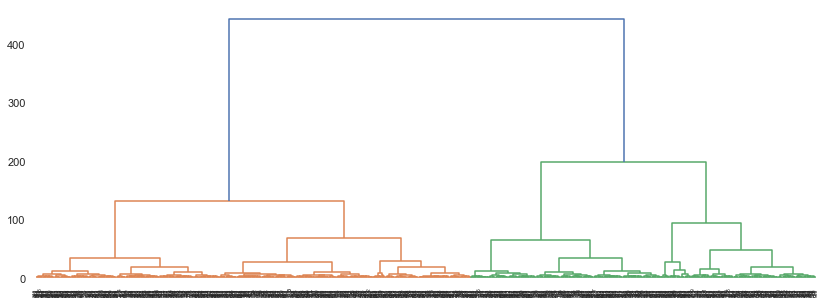

In [43]:
#Para o ward temos
plt.figure(figsize=(14,5))
mergings = linkage(df_clustering, method="ward", metric='euclidean')
dendrogram(mergings)
plt.show(True)

Fizemos alguns testes baseando-se na métrica do Silhuete Score para encontrarmos o ponto ótimo de corte para a arvore.

In [44]:
for i in range(2,20):
    df_clustering['ClusterHWard'] = cut_tree(mergings, n_clusters=i).reshape(-1, )
    print(i," - Ward's Silhouette score:", silhouette_score(df_clustering, df_clustering['ClusterHWard'], metric='euclidean'))

2  - Ward's Silhouette score: 0.5813595651258254
3  - Ward's Silhouette score: 0.5178327240229024
4  - Ward's Silhouette score: 0.46018936051137177
5  - Ward's Silhouette score: 0.4592891000984346
6  - Ward's Silhouette score: 0.45902059659391464
7  - Ward's Silhouette score: 0.4507638544377831
8  - Ward's Silhouette score: 0.4729673997902301
9  - Ward's Silhouette score: 0.49650671995252166
10  - Ward's Silhouette score: 0.5184138121388
11  - Ward's Silhouette score: 0.5043316028996516
12  - Ward's Silhouette score: 0.5031424447977649
13  - Ward's Silhouette score: 0.47545555469672046
14  - Ward's Silhouette score: 0.4465830459954663
15  - Ward's Silhouette score: 0.4308141507251539
16  - Ward's Silhouette score: 0.44563792637164695
17  - Ward's Silhouette score: 0.45584051405445225
18  - Ward's Silhouette score: 0.4509701866932091
19  - Ward's Silhouette score: 0.4556164547784083


Mesmo sem normalizar o conjunto de dados, obtivemos bons resultados das métricas de Silhouette score. O número ideal de cluster parece ser 10, ponto em que maximizamos a métrica quando olhamos para um maior número de clusters. Ajustaremos então o conjunto de dados inicial com os grupos, e depois faremos a recomendação um pouco mais personalizada.

In [45]:
df_usuarios['grupo'] = cut_tree(mergings, n_clusters=10).reshape(-1, )

In [46]:
df_usuarios.head()

,id_usuario,idade,sexo,profissao,estado_usa,grupo
0,1,24,M,technician,AZ,0
1,2,53,F,other,CA,1
2,3,23,M,writer,FL,0
3,4,24,M,technician,OH,0
4,5,33,F,other,PA,2


#### Função de recomendação

Agora desenvolveremos a função que filtrará o conjunto de dados de interação com base no cluster ao qual um dado usuário pertença. Assim, poderemos aplicar as funções acima desenvolvidas para pegar os filmes mais populares que podem ser de interesse a qualquer usuário do grupo.

In [47]:
def get_recommendations_clusterized(iid_usuario, dataframe_usuarios, dataframe, nome_coluna_id_usuario='id_usuario', nome_coluna_id_filme='id_filme', nome_coluna_grupo='grupo'):
    """
    Função que executa a métrica de média ponderada definida pela IMDB, mas apenas para as avaliações feitas no período de tempo passado como parâmetro.
    
    
    Parâmetros
    ----------
    iid_usuario: String
        O id de identificação do usuário ao qual queremos encontrar o grupo
    dataframe_usuarios: DataFrame
        Pandas DataFrame que contem as informações necessárias dos usuários
    dataframe: DataFrame
        Pandas DataFrame que contem as informações necessárias para aplicação da função
    nome_coluna_id_usuario: String
        O nome da coluna que identifica cada usuario na base de dados
    nome_coluna_id_filme: String
        O nome da coluna que identifica cada filme na base de dados
    nome_coluna_grupo: String
        O nome da coluna que identifica cada grupo na base de dados
        
    
    Retorno
    ----------
    DataFrame
        Um Pandas DataFrame que é uma cópia do dataframe das interações, mas agora filtrado pelas interações dos usuários do grupo do usuário passado como parâmetro.
    """
    
    dataframe_auxiliar = dataframe.copy()
    dataframe_auxiliar_usuarios = dataframe_usuarios.copy()
    
    grp = list(dataframe_auxiliar_usuarios[dataframe_auxiliar_usuarios[nome_coluna_id_usuario]==str(iid_usuario)][nome_coluna_grupo])[0]
    dataframe_auxiliar = dataframe_auxiliar.merge(dataframe_auxiliar_usuarios[dataframe_auxiliar_usuarios[nome_coluna_grupo]==grp][[nome_coluna_id_usuario,nome_coluna_grupo]], left_on=nome_coluna_id_usuario, right_on=nome_coluna_id_usuario, how='left')
    
    return dataframe_auxiliar[dataframe_auxiliar[nome_coluna_grupo].notna()].copy()

Vamos aplicar a função à nossa base de dados com um período de 30 dias:

In [48]:
df_resultado_popularidade_atual = current_wr_imdb(get_recommendations_clusterized(1, df_usuarios, df))

Assim podemos ver os resultados obtidos para o grupo do usuário 1 (ele pertence ao grupo 0) das 10 primeiras posições ordenadas pela popularidade atual.

In [49]:
df_resultado_popularidade_atual.merge(df_item[['id_filme','nome_filme']], left_on='id_filme', right_on='id_filme', how='left').sort_values(by='popularidade', ascending=False).head(10)

,id_filme,popularidade,nome_filme
320,313,4.109202,Titanic (1997)
54,11,4.051737,Seven (Se7en) (1995)
449,475,4.051737,Trainspotting (1996)
324,318,4.047757,Schindler's List (1993)
774,98,4.041390,"Silence of the Lambs, The (1991)"
282,272,4.041390,Good Will Hunting (1997)
232,22,4.038803,Braveheart (1995)
269,258,4.029564,Contact (1997)
84,12,3.972917,"Usual Suspects, The (1995)"
766,96,3.968404,Terminator 2: Judgment Day (1991)


Note que se escolhessemos um usuário que pertença a outro grupo, como no caso a usuária 2 (que pertence ao grupo 1), as recomendações atuais mais populares seriam outras.

In [50]:
df_resultado_popularidade_atual = current_wr_imdb(get_recommendations_clusterized(2, df_usuarios, df))
df_resultado_popularidade_atual.merge(df_item[['id_filme','nome_filme']], left_on='id_filme', right_on='id_filme', how='left').sort_values(by='popularidade', ascending=False).head(10)

,id_filme,popularidade,nome_filme
391,50,4.430350,Star Wars (1977)
2,100,4.335408,Fargo (1996)
687,98,4.335408,"Silence of the Lambs, The (1991)"
375,484,4.302490,"Maltese Falcon, The (1941)"
60,127,4.287493,"Godfather, The (1972)"
403,511,4.252075,Lawrence of Arabia (1962)
289,357,4.252075,One Flew Over the Cuckoo's Nest (1975)
496,603,4.252075,Rear Window (1954)
121,174,4.216064,Raiders of the Lost Ark (1981)
552,657,4.202490,"Manchurian Candidate, The (1962)"


Mas se por exemplo pegássemos outro usuário do grupo inicial (grupo 0), como o usuário 3 abaixo, as recomendações são as mesmas que as feitas ao usuário 1. Isso acontece porque as informações demográficas de ambos indicam que eles pertencem a esse grupo, mas não levamos em considerações as preferências individuais as quais eles optaram diretamente. Isso pode ser um ponto positivo, se você considerar usuários que ainda não tenham um histórico de preferências da base. Uma abordagem colaborativa é mais indicada se você quiser utilizar as preferencias individuais de cada um, e a veremos no próximo tópico.

In [51]:
df_resultado_popularidade_atual = current_wr_imdb(get_recommendations_clusterized(3, df_usuarios, df))
df_resultado_popularidade_atual.merge(df_item[['id_filme','nome_filme']], left_on='id_filme', right_on='id_filme', how='left').sort_values(by='popularidade', ascending=False).head(10)

,id_filme,popularidade,nome_filme
320,313,4.109202,Titanic (1997)
54,11,4.051737,Seven (Se7en) (1995)
449,475,4.051737,Trainspotting (1996)
324,318,4.047757,Schindler's List (1993)
774,98,4.041390,"Silence of the Lambs, The (1991)"
282,272,4.041390,Good Will Hunting (1997)
232,22,4.038803,Braveheart (1995)
269,258,4.029564,Contact (1997)
84,12,3.972917,"Usual Suspects, The (1995)"
766,96,3.968404,Terminator 2: Judgment Day (1991)


### Baseados em Filtragem-Colaborativa

A abordagem anterior, apesar de dar início minimamente a personalização de recomendações, sofre por não considerar os viéses e preferências individuais de cada usuário. Como dissemos no início, algorítmos baseados em filtragem colaborativa assumem o histórico cruzado entre usuários e filmes. Existem dois tipos em específico,

- Filtragem Colaborativa Baseada em Usuários

Assume que um usuário deve gostar de itens bem avaliados por usuários com gostos parecidos aos dele. Para medir a semelhança entre dois usuários, podemos usar a correlação de Pearson ou a semelhança de cosseno. Essa técnica de filtragem pode ser melhor ilustrada com um exemplo. Nas matrizes a seguir, cada linha representa um usuário, enquanto as colunas correspondem a filmes diferentes, exceto o último que registra a semelhança entre aquele usuário e o usuário alvo. Cada célula representa a avaliação que o usuário dá a algum filme. Suponha que o usuário _E_ seja o alvo.

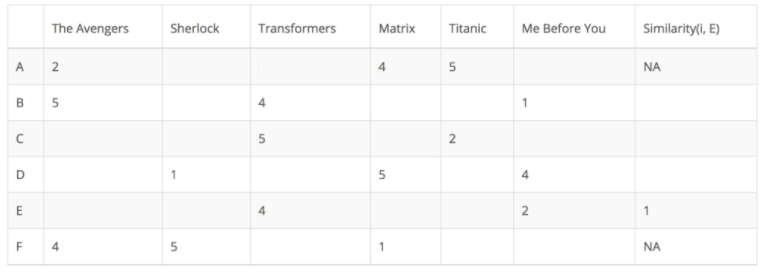

Como os usuários A e F não compartilham nenhuma classificação de filme em comum com o usuário E, suas semelhanças com o usuário E não são definidas na Correlação de Pearson. Portanto, precisamos apenas considerar os usuários B, C e D. Com base na correlação de Pearson, podemos calcular a seguinte similaridade.

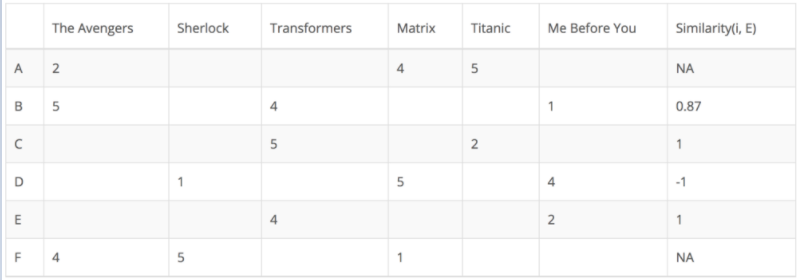

Na tabela acima, podemos ver que o usuário D é muito diferente do usuário E, pois a correlação de Pearson entre eles é negativa. Ele avaliou Me Before You acima de sua média de avaliação, enquanto o usuário E fez o oposto. Agora, podemos começar a preencher a lacuna para os filmes que o usuário E não classificou com base em outros usuários.

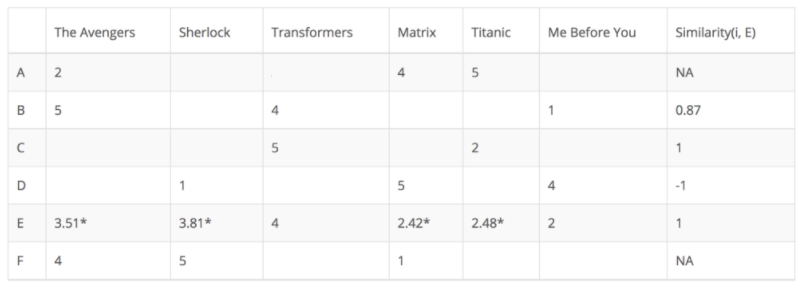

Embora computar a Filtragem Colaborativa Baseada em usuário seja muito simples, ela apresenta vários problemas. Um dos principais problemas é que as preferências dos usuários podem mudar com o tempo. Isso indica que o pré-cálculo da matriz com base nos usuários vizinhos pode levar a um desempenho ruim. Para resolver esse problema, podemos aplicar a Filtragem Colaborativa Baseada em Item.

- Filtragem Colaborativa Baseada em Item

Aqui, em vez de medir a semelhança entre os usuários, a ela recomenda itens com base em sua semelhança com os itens que o usuário-alvo classificou. Da mesma forma, a similaridade pode ser calculada com correlação de Pearson ou similaridade de cosseno. A principal diferença é que, com a Filtragem Colaborativa Baseada em Item, preenchemos o espaço em branco verticalmente, em oposição à maneira horizontal que a abordagem anterior faz. A tabela a seguir mostra como fazer isso no filme Me Before You.

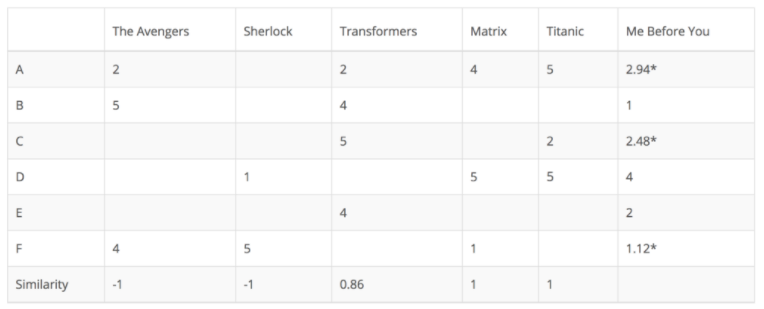

Ele evita o problema da preferência dinâmica do usuário, pois torna a similiraidade mais específica baseando-se no item. No entanto, vários problemas permanecem para este método. Primeiro, o principal problema é a escalabilidade. O cálculo cresce tanto com o cliente quanto com o produto. O pior caso de complexidade é O (mn) com m usuários e n itens. Além disso, a dispersão é outra preocupação. Dê uma olhada na tabela acima novamente. Embora haja apenas um usuário que classificou além de Me Before You, os filmes Matrix e Titanic, a semelhança entre esses dois últimos com ele é 1. Em casos extremos, podemos ter milhões de usuários e filmes e a semelhança entre dois filmes bastante diferentes pode ser muito alta simplesmente porque eles têm uma única classificação semelhante para o único usuário que classificou os dois.

#### Single Value Decomposition

Uma maneira de lidar com o problema de escalabilidade e esparsidade criado pela Filtragem Colaborativa é utilizar um modelo de Fator Latente para capturar a similaridade entre usuários e itens. O nome é bonito, parece complexo, mas a implementação é simples e, essencialmente, queremos transformar o problema de recomendação em um problema de otimização. O lado positovo de se trabalhar com modelos desse tipo é que podemos avaliar quão boa é a capacidade de prever filmes a um usuário. Uma métrica comum é o erro quadrático médio (RMSE). Quanto menor o RMSE, melhor será o desempenho do modelo.

Agora, falando sobre o Fator Latente em sí: É uma ideia ampla que descreve uma propriedade ou conceito de redução de dimensionalidade em dados. Por exemplo, para explicar uma música, um Fator Latente pode se referir ao gênero ao qual a música pertence. Seria como encontrar uma característica princiapal, ou várias delas. Descobrir uma direção não óbvia (e de forma otimizada) que possa explicar a relação entre essas características dado uma grande quantidade de filmes assistidos por diversos usuários é o objetivo desse conceito na nossa aplicação.

Parte conceitual e teórica OK, vamos de código!

As bibliotecas que utilizaremos para essa abordagem, são:

In [53]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
reader = Reader()
svd = SVD()

Para o objeto (matriz com propriedades otimizadas) precisaremos dos ids de usuário, filme e da avaliação dada por cada um deles.

In [54]:
data = Dataset.load_from_df(df[['id_usuario', 'id_filme', 'avaliacao']], reader)

Para a implementação, precisamos passar as métricas de ajuste que serão utilizadas (RSME, MAE e CFP) e também em quantas divisões o dataset é divido, no nosso caso as notas variam entre 1 e 5.

In [55]:
cross_validate(svd, data, measures=['RMSE', 'MAE', 'FCP'], cv=5)

{'test_rmse': array([0.93344495, 0.9325845 , 0.93763849, 0.93842546, 0.93502891]),
 'test_mae': array([0.73765495, 0.73553777, 0.73670823, 0.73771407, 0.73662491]),
 'test_fcp': array([0.6972019 , 0.69985066, 0.69248914, 0.70356298, 0.69692494]),
 'fit_time': (5.29620099067688,
  4.7360405921936035,
  4.826907157897949,
  4.933237314224243,
  4.607111930847168),
 'test_time': (0.23692059516906738,
  0.13326501846313477,
  0.21062946319580078,
  0.13309597969055176,
  0.19407343864440918)}

O resultado da avaliação do modelo indica que as previsões feitas poderão ter erros que variam em média 0,73 para mais ou para menos. O que é relativamente bom/aceitável.

In [56]:
trainset = data.build_full_trainset()
svd.fit(trainset)

Treinamento realizado, vamos testar um caso que anteriormente tínhamos testado com a abordagem de popularidade demográfica. Abaixo uma amostra de alguns filmes que o usuário '1' já assitiu, bem como sua avaliação para eles.

In [82]:
df[df['id_usuario'] == '1'][['id_usuario','id_filme','avaliacao']].head(3)

,id_usuario,id_filme,avaliacao
202,1,61,4
305,1,189,3
333,1,33,4


Para esse conjunto que já conhecemos, podemos verificar as previsões do modelo. Para o filme 189, em que o usuário inicialmente avaliou com a nota 3, teria como resultado no modelo a previsão de 4.10, conforme mostrado abaixo:

In [79]:
svd.predict('1', '189').est

4.108218628312328

O que contém um erro absoluto de 1.10, é um caso prático não tão bom. Mas em contrapartida, para o filme 61, o qual o usuário inicialmente avaliou como 4, recebemos pelo avaliação do modelo a nota 4.17. O que é um ajuste bem melhor do que o anterior, apesar de ainda conter o erro de 0.17 . Em média teríamos, como mencionado anteriormente, 0.73 para mais ou para menos.

In [74]:
svd.predict('1', '61').est

4.174260028208876

Agora para casos ainda não vistos para o usuários, temos uma constatação interessante. Relembrando, pela abordagem de Popularidade Demográfica as três primeiras recomendações de filmes para o usuário 1 seriam as ilustradas abaixo:

In [81]:
df_resultado_popularidade_atual = current_wr_imdb(get_recommendations_clusterized(1, df_usuarios, df))
df_resultado_popularidade_atual.merge(df_item[['id_filme','nome_filme']], left_on='id_filme', right_on='id_filme', how='left').sort_values(by='popularidade', ascending=False).head(3)

,id_filme,popularidade,nome_filme
320,313,4.109202,Titanic (1997)
54,11,4.051737,Seven (Se7en) (1995)
449,475,4.051737,Trainspotting (1996)


São os filmes mais populares de acordo com o grupo em que ele pertence. Mas com a abordagem de Filtragem Colaborativa, que é mais personalizada, teríamos que o terceiro filme tem uma maior similaridade com o usuário do que o filme primeiro filme. Conforme mostrado abaixo, para o filme 313, a nota prevista para o usuário 1 seria 3.75 .

In [71]:
svd.predict('1', '313').est

3.7529046371947348

Enquanto que para o filme 475, a nota prevista para o usuário 1 seria 4.82!

In [73]:
svd.predict('1', '475').est

4.821258467712778

### Baseados em Filtragem-Colaborativa por Redes Complexas (Link Prediction)